<h1>Where should I open a restaurant in Singapore and what cuisine shall it be?</h1>

In [130]:
import numpy as np
import pandas as pd

import json
import requests

from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium
import seaborn as sns
sns.set_style('whitegrid')

<h2>1. Obtain list of train stations and their locations in Singapore.</h2>

In [43]:
#list of all the train stations in SG
table = pd.read_csv('mrt_lrt_data.csv')

In [44]:
table = table[table['type'] == 'MRT'].copy()

In [45]:
table.drop('type',axis=1,inplace=True)

In [46]:
table.head()

,station_name,lat,lng
0,Jurong East,1.333207,103.742308
1,Bukit Batok,1.349069,103.749596
2,Bukit Gombak,1.359043,103.751863
3,Choa Chu Kang,1.385417,103.744316
4,Yew Tee,1.397383,103.747523


<h2>2. Obtain food venues around train stations from Foursquare API</h2>

In [151]:
# foursquare credentials and version
CLIENT_ID = 'G0MFJ4B0LURKDT3AQOKSV0O2UGOALOVMIQH5NWMGY0UQRVKZ' # your Foursquare ID
CLIENT_SECRET = '4DMOXLG3O1UWDGGSZGZ3QNBEBU3Y2OJH1JGGM3ZY1BDAO2DE' # your Foursquare Secret
ACCESS_TOKEN = 'VEKWOEW1JNDLU1KG4QK1FZGOU02D1VPDOVBFGRT4G5KJKG41' # your FourSquare Access Token
VERSION = '20210319' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [205]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        section = 'food'
        radius = 500
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&section={}&ll={},{}&v={}&radius{}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,section,lat,lng,VERSION,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['shortName']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [206]:
names = table['station_name']
latitudes = table['lat']
longitudes = table['lng']

results = getNearbyVenues(names,latitudes,longitudes)

In [47]:
foods = results.copy()
foods.shape

(7410, 7)

<h3>Results from the API

In [239]:
foods.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jurong East,1.333207,103.742308,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese
1,Jurong East,1.333207,103.742308,Johan Paris,1.334083,103.742384,Bakery
2,Jurong East,1.333207,103.742308,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese
3,Jurong East,1.333207,103.742308,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese
4,Jurong East,1.333207,103.742308,"Tsukada Nojo 塚田農場 Japanese ""Bijin Nabe"" Restau...",1.333718,103.742498,Japanese


In [48]:
len(foods['Venue Category'].unique())

111

<h4>Types of foods available in Singapore

In [49]:
foods['Venue Category'].unique()

array(['Chinese', 'Bakery', 'Japanese', 'Vegetarian / Vegan', 'Indian',
       'Seafood', 'Café', 'Italian', 'Hotpot', 'Korean', 'Ramen',
       'Dumplings', 'German', 'Burgers', 'Sushi', 'Halal', 'Food Court',
       'Asian', 'Sandwiches', 'Cafeteria', 'Salad', 'Dim Sum', 'BBQ',
       'Steakhouse', 'Fast Food', 'Malay', 'American', 'Thai', 'Bistro',
       'Snacks', 'Noodles', 'Indonesian', 'Buffet', 'Restaurant', 'Food',
       'Fried Chicken', 'Dutch', 'Portuguese', 'Diner', 'Vietnamese',
       'Pizza', 'Mexican', 'Hainan', 'Soup', 'Deli / Bodega',
       'Food Truck', 'Cantonese', 'Hong Kong', 'Bagels', 'Wings',
       'Middle Eastern', 'Shanghai', 'French', 'Modern European',
       'Breakfast', 'Shaanxi', 'Eastern European', 'Hakka', 'Gastropub',
       'Chinese Breakfast', 'Food Stand', 'Donuts', 'Spanish', 'English',
       'Peking Duck', 'Mediterranean', 'Soba', 'Shabu-Shabu', 'Filipino',
       'Swiss', 'Fish & Chips', 'Cuban', 'Japanese Curry', 'Creperie',
       'Kebab', 

In [50]:
features = foods[['Neighborhood','Venue Category']]

In [51]:
onehot = pd.get_dummies(data=features,columns=['Venue Category'],drop_first=True,prefix='',prefix_sep='')

In [52]:
onehot.head()

,Neighborhood,Argentinian,Aristocrat,Asian,Australian,Austrian,BBQ,Bagels,Bakery,Bistro,...,Taiwanese,Tapas,Thai,Theme Restaurant,Turkish,Udon,Vegetarian / Vegan,Vietnamese,Wings,Yunnan
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
onehot.shape

(7341, 111)

In [246]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()

In [247]:
grouped.shape

(119, 111)

In [248]:
grouped.head()

,Neighborhood,Argentinian,Aristocrat,Asian,Australian,Austrian,BBQ,Bagels,Bakery,Bistro,...,Taiwanese,Tapas,Thai,Theme Restaurant,Turkish,Udon,Vegetarian / Vegan,Vietnamese,Wings,Yunnan
0,Admiralty,0.0,0.000000,0.095238,0.0,0.0,0.000000,0.0,0.071429,0.000000,...,0.0,0.0,0.023810,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Aljunied,0.0,0.000000,0.083333,0.0,0.0,0.020833,0.0,0.020833,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,0.0,0.020833,0.0
2,Ang Mo Kio,0.0,0.000000,0.038462,0.0,0.0,0.038462,0.0,0.019231,0.019231,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,Bartley,0.0,0.018868,0.056604,0.0,0.0,0.018868,0.0,0.056604,0.018868,...,0.0,0.0,0.018868,0.000000,0.0,0.0,0.037736,0.0,0.000000,0.0
4,Bayfront,0.0,0.000000,0.040404,0.0,0.0,0.000000,0.0,0.010101,0.030303,...,0.0,0.0,0.010101,0.010101,0.0,0.0,0.000000,0.0,0.000000,0.0


<h3>Top ten cuisines in each area

In [55]:
columns = ['Neighborhood'] + [x for x in range(1,11)]
all_rankings = pd.DataFrame(columns=columns)

for hood in grouped['Neighborhood']:
    top = {}
    rankings = grouped[grouped['Neighborhood'] == hood]
    rankings.set_index('Neighborhood',inplace=True)
    top_10 = rankings.sort_values(by=hood,axis=1,ascending=False).iloc[0][:10].index.to_list()
    count = 1
    for x in top_10:
        top[count] = x
        count += 1
    top['Neighborhood'] = hood
    all_rankings = all_rankings.append(top,ignore_index=True)

In [56]:
all_rankings.head()

,Neighborhood,1,2,3,4,5,6,7,8,9,10
0,Admiralty,Food Court,Café,Asian,Japanese,Chinese,Indian,Fast Food,Pizza,Sandwiches,Bakery
1,Aljunied,Chinese,Noodles,Asian,Food Court,Vegetarian / Vegan,Dim Sum,Seafood,Indian,Thai,Café
2,Ang Mo Kio,Food Court,Fast Food,Sushi,Japanese,Indian,Asian,Sandwiches,BBQ,Snacks,Breakfast
3,Bartley,Food Court,Chinese,Café,Asian,Noodles,Seafood,Bakery,Indian,Vegetarian / Vegan,Fast Food
4,Bayfront,Café,Chinese,Japanese,Italian,Asian,Sandwiches,Sushi,Bistro,Food Court,Dim Sum


In [58]:
all_rankings

,Neighborhood,1,2,3,4,5,6,7,8,9,10
0,Admiralty,Food Court,Café,Asian,Japanese,Chinese,Indian,Fast Food,Pizza,Sandwiches,Bakery
1,Aljunied,Chinese,Noodles,Asian,Food Court,Vegetarian / Vegan,Dim Sum,Seafood,Indian,Thai,Café
2,Ang Mo Kio,Food Court,Fast Food,Sushi,Japanese,Indian,Asian,Sandwiches,BBQ,Snacks,Breakfast
3,Bartley,Food Court,Chinese,Café,Asian,Noodles,Seafood,Bakery,Indian,Vegetarian / Vegan,Fast Food
4,Bayfront,Café,Chinese,Japanese,Italian,Asian,Sandwiches,Sushi,Bistro,Food Court,Dim Sum
...,...,...,...,...,...,...,...,...,...,...,...
114,Woodleigh,Chinese,Food Court,Bakery,Asian,Seafood,Fast Food,Café,Indian,Noodles,Food
115,Yew Tee,Asian,Fast Food,Food Court,Cafeteria,Restaurant,Café,Italian,Diner,Snacks,Pizza
116,Yio Chu Kang,Food Court,Cafeteria,Café,Noodles,Japanese,Chinese,Restaurant,Food Truck,French,Shanghai
117,Yishun,Chinese,Food Court,Fast Food,Fried Chicken,Ramen,Italian,Noodles,Bakery,Hainan,Café


<h4>Chinese food is the most popular in Singapore, closely followed by food courts and cafes. Food courts provide various cuisines and cafes do not provide information as to cuisine (but likely Western).

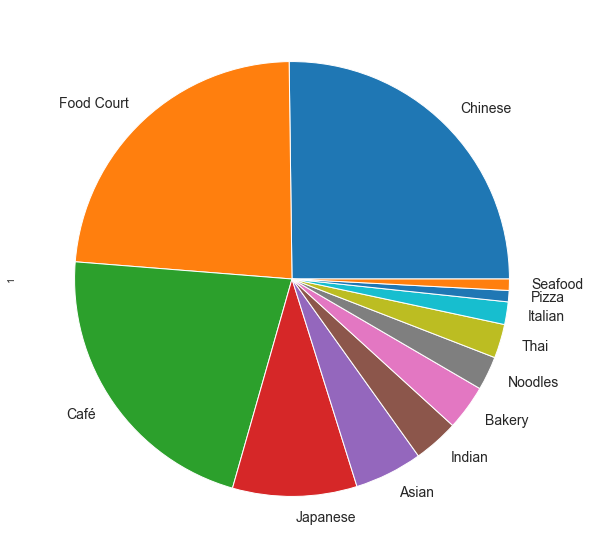

In [132]:
all_rankings[1].value_counts().plot.pie(figsize=(10,10),textprops={'fontsize': 14})
plt.savefig('pie.jpeg')

<AxesSubplot:ylabel='3'>

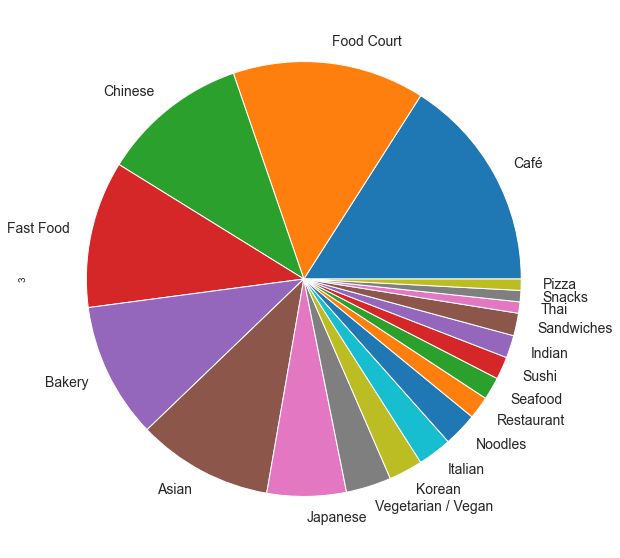

In [76]:
all_rankings[3].value_counts().plot.pie(figsize=(10,10),textprops={'fontsize': 14})

<h2>3. Using clustering to find patterns in the data

In [252]:
kclusters = 6

grouped_clustering = grouped.drop('Neighborhood',1)

kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(grouped_clustering)

kmeans.labels_[0:10]

array([2, 0, 3, 3, 1, 2, 0, 3, 0, 1], dtype=int32)

In [253]:
all_rankings.insert(0, 'Cluster Labels', kmeans.labels_)
merged = table
merged = merged.join(all_rankings.set_index('Neighborhood'),on='station_name')
merged.head()

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
0,Jurong East,1.333207,103.742308,2,Café,Japanese,Chinese,Food Court,Asian,Fast Food,Sandwiches,Bakery,Seafood,Korean
1,Bukit Batok,1.349069,103.749596,3,Food Court,Chinese,Bakery,Asian,Vegetarian / Vegan,Fast Food,Café,Pizza,Restaurant,Italian
2,Bukit Gombak,1.359043,103.751863,3,Food Court,Chinese,Asian,Restaurant,Café,Halal,Fast Food,Seafood,Italian,Fried Chicken
3,Choa Chu Kang,1.385417,103.744316,2,Fast Food,Café,Food Court,Chinese,Restaurant,Italian,Mexican,Vegetarian / Vegan,Snacks,Bakery
4,Yew Tee,1.397383,103.747523,3,Fast Food,Asian,Restaurant,Food Court,Snacks,Sandwiches,Pizza,Japanese,Bakery,Chinese


In [254]:
# create map
map_clusters = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['lat'], merged['lng'], merged['station_name'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [113]:
popular_cluster = pd.DataFrame(columns=['Cluster','Areas','Most popular food venue','2nd most popular food venue','3rd most popular food venue'])

def remove(string):
    for x in string:
        try:
            if int(x):
                string = string.replace(x,'')
        except:
            continue
    string = string.replace(' ','')
    string = string.replace(',',', ')
    return string

for k in range(kclusters):
    first = remove(merged[merged['Cluster Labels'] == k][1].value_counts().to_string().replace('\n',', '))
    second = remove(merged[merged['Cluster Labels'] == k][2].value_counts().to_string().replace('\n',', '))
    third = remove(merged[merged['Cluster Labels'] == k][3].value_counts().to_string().replace('\n',', '))
    popular_cluster = popular_cluster.append({'Cluster':k,
                            'Areas':', '.join(merged[merged['Cluster Labels'] == k]['station_name'].to_list()),
                            'Most popular food venue':first,
                            '2nd most popular food venue':second,
                            '3rd most popular food venue':third},
                          ignore_index=True)
    print('Label:', k)
    print()
    print('MOST POPULAR SHOPS')
    print(merged[merged['Cluster Labels'] == k][1].value_counts())
    print()
    print('SECOND MOST POPULAR')
    print(merged[merged['Cluster Labels'] == k][2].value_counts())
    print()
    print('AREAS')
    print(merged[merged['Cluster Labels'] == k]['station_name'].to_list())
    print()

Label: 0

MOST POPULAR SHOPS
Café        17
Japanese     1
Chinese      1
Name: 1, dtype: int64

SECOND MOST POPULAR
Chinese     7
Japanese    5
Asian       3
Café        2
Sushi       1
Mexican     1
Name: 2, dtype: int64

AREAS
['Jurong East', 'Novena', 'Newton', 'Dhoby Ghaut', 'Marina Bay', 'Dover', 'Expo', 'Changi Airport', 'Lorong Chuan', 'Botanic Gardens', 'one-north', 'Kent Ridge', 'Haw Par Villa', 'Pasir Panjang', 'Bayfront', 'Beauty World', 'Downtown', 'Bencoolen', 'Upper Changi']

Label: 1

MOST POPULAR SHOPS
Chinese       15
Noodles        2
Food Court     1
Name: 1, dtype: int64

SECOND MOST POPULAR
Asian                 8
Food Court            3
Noodles               3
Chinese               2
Vegetarian / Vegan    1
Café                  1
Name: 2, dtype: int64

AREAS
['Braddell', 'Chinese Garden', 'Commonwealth', 'Redhill', 'Tiong Bahru', 'Aljunied', 'Eunos', 'Kembangan', 'Tanah Merah', 'Boon Keng', 'Potong Pasir', 'Woodleigh', 'Mountbatten', 'Dakota', 'Bendemeer', 'Geyla

In [114]:
popular_cluster.to_csv('clusters.csv')

<h3>General observations from above data:</h3>
    <p>There are predominant cuisines in three areas:</p>
    <ul>
        <li>Central area (Label 1) has many Japanese food places and cafes.
        <li>Little India (Label 5) naturally has many Indian food places.
        <li>Certain suburbs (Label 0) have many Chinese and Asian food places.

<p><strong>Central area</strong>: Given the popularity of Japanese food in this group, it might be worth opening Japanese restaurants where there are fewer ones  - Marina Bay, Nicoll Highway and Outram Park. Also, a Japanese cafe might be very well-received.

In [128]:
merged[(merged['Cluster Labels']==4) & (merged[1] != 'Japanese')  & (merged[2] != 'Japanese') & (merged[3] != 'Japanese')].drop(columns=['lat','lng','Cluster Labels'])

,station_name,1,2,3,4,5,6,7,8,9,10
37,Buona Vista,Café,Bakery,Food Court,Chinese,Japanese,Indian,Noodles,Mexican,Asian,Salad
42,Outram Park,Italian,Chinese,Korean,Food Court,Tapas,Seafood,Japanese,Asian,French,Australian
75,Nicoll Highway,Thai,Restaurant,Café,Italian,Vietnamese,Bakery,Steakhouse,Asian,Indonesian,Indian
86,Farrer Road,Bakery,Café,Chinese,Italian,Noodles,Japanese,Indian,Pizza,Thai,French


<p><strong>Little India</strong>: Demand for Indian food appears to be concentrated around four train stations.</p>

In [282]:
merged[merged['Cluster Labels']==5]

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
61,Little India,1.306691,103.849396,5,Indian,Vegetarian / Vegan,Café,Chinese,Fast Food,Food,Food Court,Restaurant,Shabu-Shabu,Cuban
62,Farrer Park,1.312679,103.854872,5,Indian,Chinese,Café,Asian,Vegetarian / Vegan,Soup,Food Court,Seafood,Noodles,BBQ
103,Rochor,1.303601,103.852581,5,Indian,Café,Vegetarian / Vegan,Chinese,Bakery,Japanese,Sushi,Food Court,Ramen,Shabu-Shabu
108,Jalan Besar,1.305551,103.855443,5,Indian,Chinese,Café,Asian,Indonesian,Vegetarian / Vegan,Bakery,Restaurant,Food Court,Thai


Other neighbourhoods where Indian food is among top 5 (mostly outside the central area):

In [287]:
merged[merged[3]=='Indian']

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
90,Haw Par Villa,1.283149,103.781991,2,Asian,Café,Indian,Chinese,Food Court,Sandwiches,Breakfast,Korean,Vietnamese,Restaurant
116,Tampines West,1.345583,103.938244,3,Fast Food,Bakery,Indian,Food Court,Halal,Malay,Noodles,Vegetarian / Vegan,Seafood,Chinese


In [288]:
merged[merged[4]=='Indian']

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
35,Clementi,1.314925,103.765341,3,Food Court,Chinese,Asian,Indian,Steakhouse,Noodles,Thai,Fast Food,Fried Chicken,Pizza
67,Kovan,1.360207,103.885163,0,Chinese,Noodles,Food Court,Indian,Bakery,Café,Pizza,Snacks,Dim Sum,Thai
69,Buangkok,1.382991,103.893347,0,Chinese,Food Court,Noodles,Indian,Asian,Bakery,Thai,Snacks,Wings,Fried Chicken
114,Bedok North,1.335268,103.918054,3,Food Court,Asian,Fast Food,Indian,Chinese,Thai,Café,Seafood,Bakery,Japanese


In [289]:
merged[merged[5]=='Indian']

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
13,Ang Mo Kio,1.370025,103.849588,3,Food Court,Fast Food,Sushi,Japanese,Indian,Chinese,Steakhouse,Asian,Sandwiches,BBQ
87,Holland Village,1.311189,103.796119,0,Chinese,Food Court,Bakery,Café,Indian,Asian,Salad,Noodles,Pizza,Vegetarian / Vegan
89,Kent Ridge,1.293629,103.784441,2,Café,Asian,Food Court,Sandwiches,Indian,Korean,Thai,Salad,Restaurant,Chinese
113,Kaki Bukit,1.335076,103.909057,4,Food Court,Asian,Chinese,Thai,Indian,Restaurant,Bakery,Café,Seafood,Fast Food


<p><strong>Chinese food</strong>: Chinese food is wildly popular in many areas.</p>

In [291]:
merged[merged['Cluster Labels']==0]

,station_name,lat,lng,Cluster Labels,1,2,3,4,5,6,7,8,9,10
9,Sembawang,1.449133,103.820060,0,Chinese,Food Court,Asian,Fast Food,Café,Buffet,Food,Steakhouse,Sushi,Japanese
10,Yishun,1.429666,103.835044,0,Chinese,Food Court,Café,Fast Food,Fried Chicken,Sushi,Hainan,Italian,Bakery,Vegetarian / Vegan
15,Braddell,1.340550,103.847098,0,Noodles,Chinese,Food Court,Bakery,Asian,Seafood,Café,Hakka,Fast Food,Thai
16,Toa Payoh,1.332405,103.847436,0,Chinese,Food Court,Fast Food,Asian,Snacks,Bakery,Noodles,Dim Sum,Steakhouse,Cafeteria
34,Chinese Garden,1.342436,103.732582,0,Chinese,Food Court,Café,Seafood,Asian,Indian,Fast Food,Thai,Noodles,Malay
38,Commonwealth,1.302439,103.798326,0,Chinese,Asian,Café,Noodles,Food Court,Indian,BBQ,Vegetarian / Vegan,Fast Food,Salad
39,Queenstown,1.294867,103.805902,0,Chinese,Café,Food Court,Noodles,Asian,BBQ,Malay,Korean,Seafood,Vegetarian / Vegan
40,Redhill,1.289674,103.816787,0,Chinese,Food Court,Café,Asian,Bakery,Fast Food,Noodles,Indian,Malay,Pizza
41,Tiong Bahru,1.286555,103.826956,0,Chinese,Café,Food Court,Asian,Noodles,Bakery,Fast Food,Japanese,Snacks,Soup
46,Kallang,1.311532,103.871372,0,Chinese,Café,Thai,Asian,Snacks,Italian,Soup,Dim Sum,Noodles,Indian
